<a href="https://colab.research.google.com/github/MakowToms/DeepLearning/blob/main/speech/Speech_Recog_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Command Recognition 

Source: https://github.com/douglas125/SpeechCmdRecognition

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [ ]:
# restart environment (use only if necessary)
import os
os.kill(os.getpid(), 9)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6MD9UcGhb7hswIMv5typ8gqW8f83uFbZSbRzADbldmGp7L94AuTkM
Mounted at /content/drive


# Preprocessing

In [15]:
# unpack data on disk
import zipfile

zip_file = "drive/MyDrive/speech_data/$name.zip"
unzip_train = True
unzip_test = True

try:
  if unzip_train:
    with zipfile.ZipFile(zip_file.replace('$name', 'train')) as z:
        z.extractall('speech_data')
  if unzip_test:
    with zipfile.ZipFile(zip_file.replace('$name', 'test')) as z:
        z.extractall('speech_data')
    print("Extracted all")
except:
    print("Invalid file")

## Processing


In [8]:
!rm SpeechDownloader.py
!rm SpeechGenerator.py
!rm SpeechModels.py
!rm audioUtils.py
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/audioUtils.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechModels.py

In [1]:
#%load_ext autoreload
#%autoreload 2

import os
import random
import librosa
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [2]:
!pip install tensorflow-determinism

import tensorflow as tf
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
os.environ['TF_DETERMINISTIC_OPS'] = '1'

def set_seed(seed=123):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  
set_seed()


In [3]:
# Download and prepare all data
# changelog: 35word into 12cmd; version 2 into 1
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(task='12cmd', drive_directory='')

Done preparing Google Speech commands dataset version 0


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [4]:
print(gscInfo.keys())
# print(gscInfo['train'].keys())
# print(len(gscInfo['train']['files']))
print(nCategs)
len(gscInfo['testREAL']['files'])
# print(np.unique(list(gscInfo['test']['labels'].values())))
# len([l for l in gscInfo['train']['labels'].values() if l == 1])


dict_keys(['train', 'test', 'val', 'testREAL'])
12


158538

# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [4]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], 'train', shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], 'val', shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], 'test', shuffle=False, batch_size=len(gscInfo['test']['files']))
try:
  testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], 'test', shuffle=False, batch_size=int(len(gscInfo['testREAL']['files'])/6))
  print(testRGen.__len__())
except:
  print('Cannot create test dataset')
print(valGen.__len__())
print(len(gscInfo['testREAL']['files']))
print(len(gscInfo['testREAL']['labels']))
print(len(gscInfo['test']['files']))
print(len(gscInfo['test']['labels']))


6
93
158538
158538
7051
6841


In [6]:
# labels_df = pd.DataFrame(gscInfo['train']['labels'].items())
# counts = labels_df.groupby(1).count()[0]
# n_unknown = counts[0]
# print(n_unknown)
# silence_labels = list(labels_df[labels_df.iloc[:, 1] == 1].iloc[:, 0])
# print(len(silence_labels))
# print(len(trainGen.list_IDs))

32550
6
52636


# Spectrograms

In [ ]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


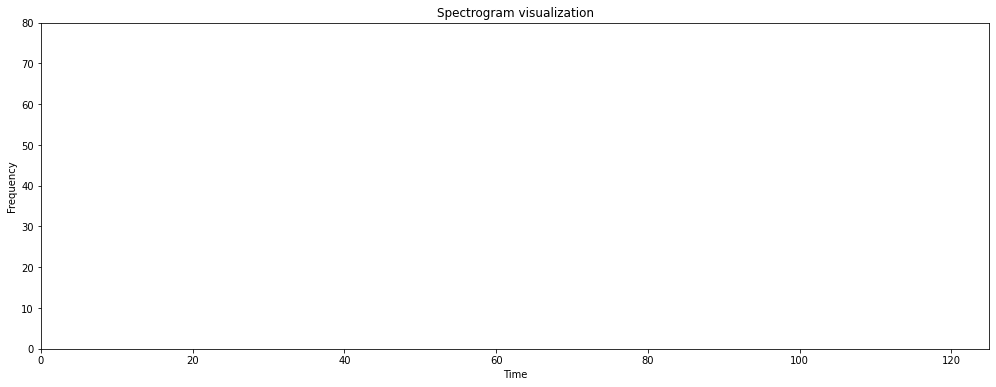

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

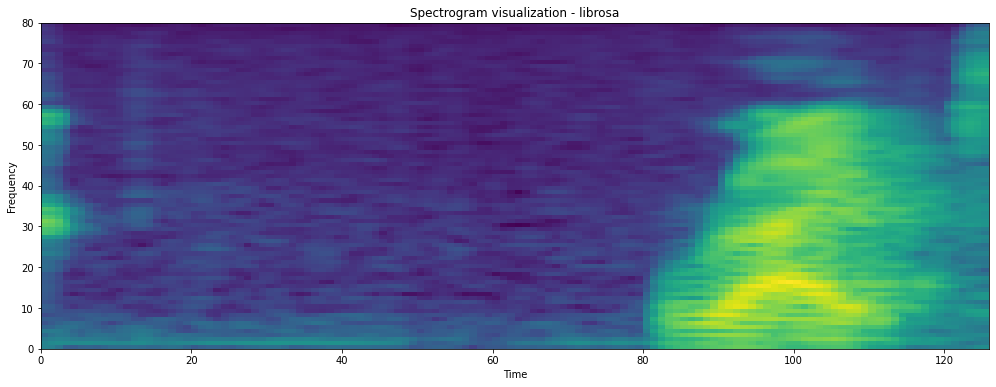

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

## Learn

In [5]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [6]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

set_seed()
model = SpeechModels.ConvSpeechModel(nCategs, samplingrate = sr, inputLength = 16000)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "ConvSpeechModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
_________________________________________________________________
permute (Permute)            (None, 125, 80, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 80, 20)       120       
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 80, 20)   

In [7]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [8]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-12cmd-CNN2.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-12cmd-CNN2.h5')

Epoch 1/60
Changing learning rate to 0.001
 12/675 [..............................] - ETA: 17:31 - loss: 7.0439 - sparse_categorical_accuracy: 0.0921

KeyboardInterrupt: ignored

## Plot

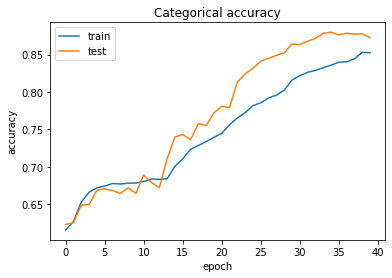

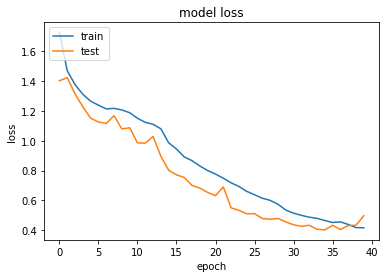

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# results.history

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-silence-CNN2.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.23944488167762756, 0.9204480051994324] 
Validation: [0.3991874158382416, 0.8797348737716675] 
Test: [0.4310758411884308, 0.874782145023346]


## Kaggle

In [ ]:
# # x_testR = testRGen.__getitem__(0)[0]
# # print(len(x_testR))
# list_IDs_temp = testRGen.list_IDs[:100]
# shapes = []
# X = np.zeros((100, testRGen.dim))
# for i, ID in enumerate(list_IDs_temp):
#     # load data from file, saved as numpy array on disk
#     curX = np.load(ID)
#     X[i] = curX
#     shapes.append(curX.shape[0])
# files_real = gscInfo['testREAL']['files'][:100]
# print(shapes)
# print(testRGen.dim)
# print(len(testRGen))

# X2 = testRGen.__getitem__(0)[0][:100, :]
# print(np.sum(X == X2))
# print(X.shape)
# np.array(list_IDs_temp) == np.array(files_real)

In [ ]:
kaggle12cmd = True
# classes=['unknown', 'silence', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
classes=['nothing', 'silence']
all_preds = []
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    # x_testR, y_testR = testRGen.__getitem__(0)
    for i in range(6):
        x_testR = None
        x_testR = testRGen.__getitem__(i)[0]
        # print(len(x_testR))
        # print(x_testR.list_IDs)
        y_pred = model.predict(x_testR, verbose=1)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [classes[i] for i in y_pred]
        all_preds += y_pred


826/826 [==============================] - 340s 411ms/step


In [ ]:
files = gscInfo['testREAL']['files']
files = [file.split('/')[-1][:-4] for file in files]
submissions=pd.DataFrame({"fname": files,
                          "label": all_preds[:len(files)]})
submissions.to_csv("submission.csv", index=False)

In [ ]:
submissions.groupby('label').count()

,fname
label,
nothing,145131
silence,13407


In [ ]:
!pip install kaggle
try:
    os.mkdir('/root/.kaggle')
except:
    pass
with open('/root/.kaggle/kaggle.json', 'w') as f:
    # have to write your own credentials (can be found in account menu)
    f.write('{"username":"pi1415926535","key":"03c523ea41beb4e2f98f9029b47d8701"}')
!kaggle competitions submit -c tensorflow-speech-recognition-challenge -f submission.csv -m "silence-CNN2 (13407 silence)"

100% 4.08M/4.08M [00:00<00:00, 9.21MB/s]
Successfully submitted to TensorFlow Speech Recognition Challenge

## Evaluation and Attention Plots

## Some plots

In [ ]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [ ]:
audios, classes = valGen.__getitem__(3)
classes

array([ 0,  0,  0,  0,  0,  8,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,
        0,  0,  3,  0,  0,  0,  2,  0,  0,  0, 11,  0,  0,  4,  9])

In [ ]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

0

In [ ]:
outs, attW, specs = attSpeechModel.predict(audios)

In [ ]:
np.argmax(outs,axis=1)

array([ 0,  0,  0,  0,  0,  8,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,
        0, 10,  3,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  4,  9])

In [ ]:
specs.shape

(32, 80, 125, 1)

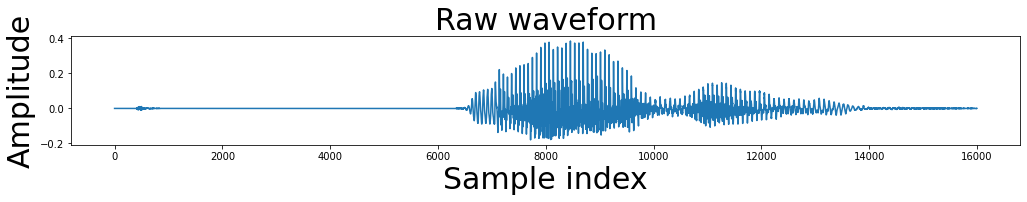

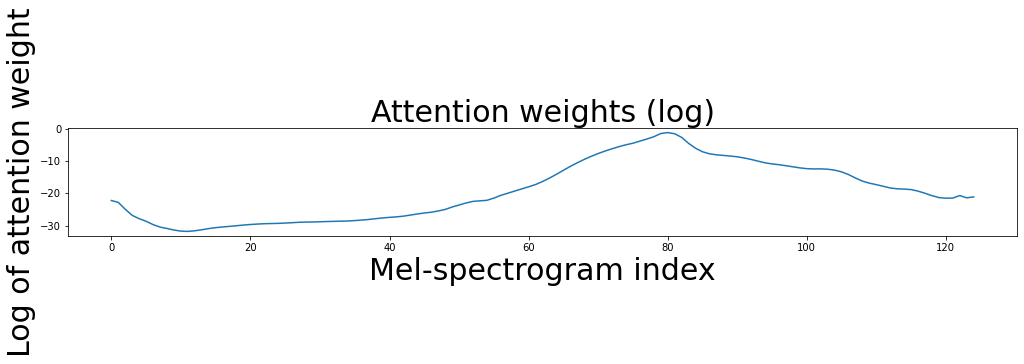

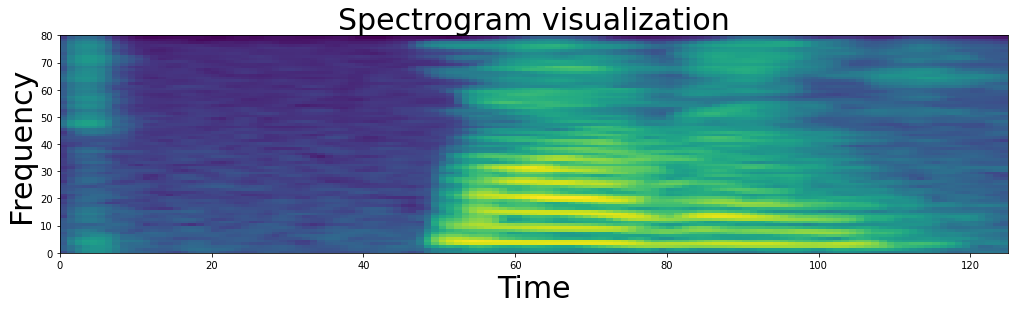

In [ ]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

## Confusion matrix

In [ ]:
# x_test, y_test = testGen.__getitem__(0)
y_pred = model.predict(x_test, verbose=1)

234/234 [==============================] - 4s 18ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#12cmd
classes=['unknown', 'silence', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
# classes=['unknown', 'silence']

Confusion matrix, without normalization


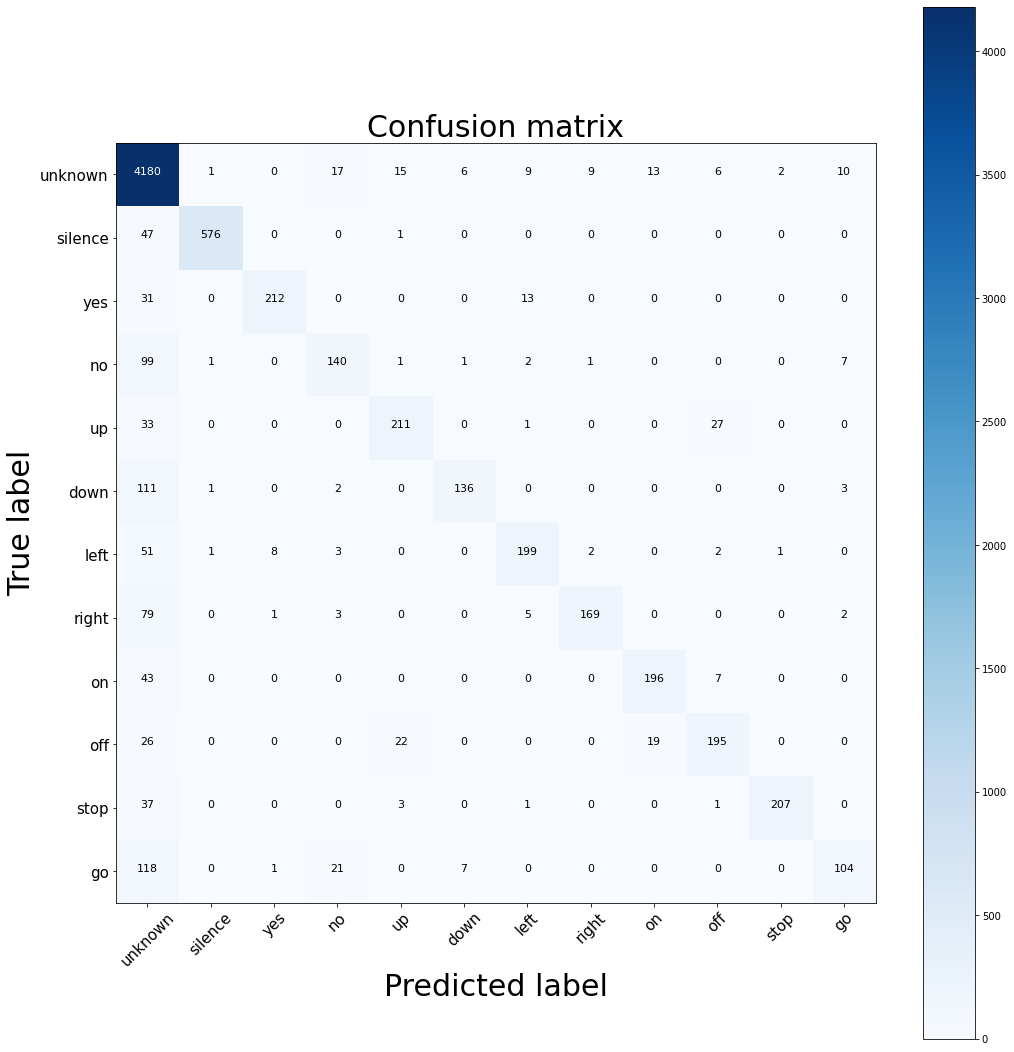

In [ ]:

audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.4.1', '0.2.0', '1.1.5', '0.8.0']

# Save model to .pb

In [ ]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights('model-attRNN.h5')

model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [ ]:
tf.saved_model.save(model, "attRNNModel/1/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: attRNNModel/1/assets


In [ ]:
import os
os.listdir('attRNNModel/1/')

['assets', 'saved_model.pb', 'variables']

In [ ]:
# if using tensorflow 1.x

In [ ]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [ ]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

#frozen_graph = freeze_session(sess,
#                              output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)